<a href="https://colab.research.google.com/github/JONADA-TEJAS/capstone_project_sa/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


df = pd.read_csv("/content/dataset (1).csv")


df["timestamp"] = df["LastUpdatedDate"].astype(str) + " " + df["LastUpdatedTime"].astype(str)


traffic_map = {"low": 2, "average": 5, "high": 8}
df["TrafficConditionNearby"] = df["TrafficConditionNearby"].map(traffic_map).fillna(df["TrafficConditionNearby"]).astype(float)


df = df.rename(columns={
    "SystemCodeNumber": "parking_lot_id",
    "Latitude": "latitude",
    "Longitude": "longitude",
    "Capacity": "capacity",
    "Occupancy": "occupancy",
    "QueueLength": "queue_length",
    "VehicleType": "vehicle_type",
    "TrafficConditionNearby": "traffic_level",
    "IsSpecialDay": "is_special_day"
})


df_clean = df[[
    "timestamp", "parking_lot_id", "latitude", "longitude", "capacity",
    "occupancy", "queue_length", "vehicle_type", "traffic_level", "is_special_day"
]]


df_clean.to_csv("clean_dataset_final.csv", index=False)
print(" Data cleaned and saved as clean_dataset.csv")

 Data cleaned and saved as clean_dataset.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pathway
import pathway as pw
class ParkingRecord(pw.Schema):
    timestamp: str
    parking_lot_id: str
    latitude: float
    longitude: float
    capacity: int
    occupancy: int
    queue_length: int
    vehicle_type: str
    traffic_level: float
    is_special_day: int


input_table = pw.io.csv.read(
    "/content/clean_dataset_final.csv",
    schema=ParkingRecord,
    mode="streaming",
    autocommit_duration_ms=500
)


BASE_PRICE = 10.0
vehicle_weights = {"car": 1.0, "bike": 0.5, "truck": 2.0}

@pw.udf
def model1_price(occupancy, capacity):
    alpha = 2.0
    return BASE_PRICE + alpha * (occupancy / capacity)

@pw.udf
def model2_price(capacity, occupancy, queue_length, traffic_level, is_special_day, vehicle_type):
    alpha = 3.0
    beta = 1.5
    gamma = 2.0
    delta = 5.0
    vehicle_weight = vehicle_weights.get(vehicle_type.lower(), 1.0)
    demand = (alpha * (occupancy / capacity) + beta * queue_length -
              gamma * traffic_level + delta * is_special_day + vehicle_weight)
    norm_demand = min(max(demand / 100, 0), 1)
    return max(min(BASE_PRICE * (1 + 1.5 * norm_demand), BASE_PRICE * 2), BASE_PRICE * 0.5)

@pw.udf
def model3_price_simple(occupancy, capacity, queue_length, traffic_level, base_price):
    if occupancy >= capacity and queue_length > 2:
        return max(base_price - 1.0, BASE_PRICE * 0.5)
    elif traffic_level > 5:
        return min(base_price + 1.0, BASE_PRICE * 2)
    return base_price


with_prices = input_table.with_columns(
    price_model_1=model1_price(input_table.occupancy, input_table.capacity),
    price_model_2=model2_price(
        input_table.capacity,
        input_table.occupancy,
        input_table.queue_length,
        input_table.traffic_level,
        input_table.is_special_day,
        input_table.vehicle_type
    )
)

model3 = with_prices.with_columns(
    price_model_3=model3_price_simple(
        with_prices.occupancy,
        with_prices.capacity,
        with_prices.queue_length,
        with_prices.traffic_level,
        with_prices.price_model_2
    )
)


pw.io.csv.write(model3, "output.csv")
pw.run()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 15

Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


KeyboardInterrupt: 

In [ ]:
df=pd.read_csv('/content/output.csv')
df

,timestamp,parking_lot_id,latitude,longitude,capacity,occupancy,queue_length,vehicle_type,traffic_level,is_special_day,price_model_1,price_model_2,price_model_3,time,diff
0,29-10-2016 12:06:00,BHMNCPNST01,26.140048,91.730972,485,308,7,car,8.0,0,11.270103,10.000000,11.000000,1751829441064,1
1,26-11-2016 16:01:00,BHMBCCTHL01,26.144495,91.736205,387,402,2,car,2.0,0,12.077519,10.467442,10.467442,1751829441064,1
2,08-12-2016 16:32:00,BHMBCCMKT01,26.144536,91.736172,577,105,2,car,2.0,0,10.363951,10.081889,10.081889,1751829441064,1
3,07-11-2016 11:59:00,BHMBCCTHL01,26.144495,91.736205,387,280,5,car,5.0,0,11.447028,10.100581,10.100581,1751829441064,1
4,04-10-2016 16:04:00,Others-CCCPS98,26.147500,91.727978,3103,1019,3,car,2.0,0,10.656784,10.372776,10.372776,1751829441064,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18363,12-10-2016 14:03:00,Others-CCCPS119a,26.147541,91.727970,2803,582,4,car,5.0,0,10.415269,10.000000,10.000000,1751829441064,1
18364,15-11-2016 11:30:00,Others-CCCPS8,26.147549,91.727995,1322,736,6,car,5.0,0,11.113464,10.250530,10.250530,1751829441064,1
18365,13-12-2016 12:29:00,BHMBCCMKT01,26.144536,91.736172,577,216,7,car,8.0,0,10.748700,10.000000,11.000000,1751829441064,1
18366,19-11-2016 15:31:00,Others-CCCPS98,26.147500,91.727978,3103,1146,3,bike,2.0,0,10.738640,10.316194,10.316194,1751829441064,1


In [ ]:
df["revenue_model_1"] = df["price_model_1"] * df["occupancy"]
df["revenue_model_2"] = df["price_model_2"] * df["occupancy"]
df["revenue_model_3"] = df["price_model_3"] * df["occupancy"]
avg_revenue = {
    "Model 1": df["revenue_model_1"].mean(),
    "Model 2": df["revenue_model_2"].mean(),
    "Model 3": df["revenue_model_3"].mean()
}

for model, revenue in avg_revenue.items():
    print(f"{model} Average Revenue: ₹{revenue:.2f}")



Model 1 Average Revenue: ₹8141.92
Model 2 Average Revenue: ₹7555.18
Model 3 Average Revenue: ₹7737.10


In [ ]:
revenue_by_lot = df.groupby("parking_lot_id")[[
    "revenue_model_1", "revenue_model_2", "revenue_model_3"
]].sum().round(2)

revenue_by_lot.head()

,revenue_model_1,revenue_model_2,revenue_model_3
parking_lot_id,,,
BHMBCCMKT01,2290125.37,2156399.76,2222701.76
BHMBCCTHL01,4404807.25,3897588.84,3865386.84
BHMEURBRD01,4584840.30,4057381.76,4157033.76
BHMMBMMBX01,7187974.66,6456953.37,6612260.37
BHMNCPHST01,8107985.88,7482439.99,7674351.99


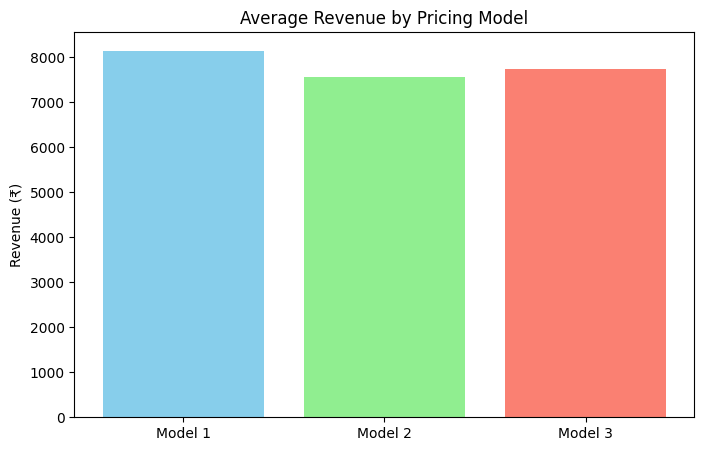

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(avg_revenue.keys(), avg_revenue.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Average Revenue by Pricing Model")
plt.ylabel("Revenue (₹)")
plt.show()

In [ ]:

import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
output_notebook()


df = pd.read_csv("/content/output.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

lot_id = "BHMBCCMKT01"
df_lot = df[df["parking_lot_id"] == lot_id].sort_values("timestamp")


source = ColumnDataSource(df_lot)


p = figure(x_axis_type="datetime", height=400, width=800,
           title=f"Dynamic Pricing Over Time for Parking Lot {lot_id}",
           tools="pan,wheel_zoom,box_zoom,reset,save")


p.line("timestamp", "price_model_1", source=source, line_width=2, color="blue", legend_label="Model 1")
p.line("timestamp", "price_model_2", source=source, line_width=2, color="green", legend_label="Model 2")
p.line("timestamp", "price_model_3", source=source, line_width=2, color="red", legend_label="Model 3")


p.legend.location = "top_left"
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price (₹)"
p.title.text_font_size = "16pt"


show(p)

/tmp/ipython-input-8-3044359514.py:9: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"])
